In [60]:
import os
import time
from typing import Optional

import numpy as np
import pandas as pd
import catboost as cb
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from teacher_bot.risk_default_prediction import RiskDefaultPrediction
pd.set_option("display.max_columns", 150)

## Описание задачи

__Задача кредитного скоринга__ – одна из наиболее распространенных задач среди задач бинарной классификации, которые хорошо решаются в бизнесе. Скоринговые модели строятся в разных областях бизнеса, но наиболее известные - это баковская сфера и телеком-операторы. Сегодня, мы разберемся с ключевыми шагами для написания собственной скоринговой модели на `Python`.

Два наиболее важных вопроса кредитования:

* Насколько рискованно поступает заемщик, беря кредит?
* Учитывая известный риск заемщика, должны ли мы его кредитовать?

Определить рискованность действий заемщика можно опираясь на данные об экономическом поведении как его самого, так и результаты кредитования предыдущих заемщиков.

## Для чего нужна скоринговая модель?

Вопрос, который максимально интересует банкиров в вопросе кредитования заемщиков — это сможет ли заемщик вернуть кредит. Соответственно, все модели будут пытаться предугадать вероятность возврата (или дефолта) данного заемщика на основе имеющихся факторов и данных. В реальной жизни при построении моделей маишнного обучения мы сталкиваемся с неполными данными, поэтому нужно обратить особое внимание на два момента:

* Что делать, если часть данных отсутствует?
* Как строить модели для несбалансированных выборок?
* Как объединить данные из разных источников?
* Как объединить дублирующие данные?

Будем работать с реальными данными, которые мы рассматривали в уроке про создание новых признаков. В данной задаче, мы имеем несколько разных источников данных:

* `application.csv` - данные из анкеты клиента;
* `previous_application.csv` - данные из предыдущих анкет клиентов (исторические заявки);
* `installments_payments.csv` - история совершенных платежей по кредитам;
* `bureau.csv` - данные, полученные из бюро кредитных историй;
* `bureau_balance.csv` - данные, полученные из бюро кредитный историй (информация по балансам);
* `credit_card_balance.csv` - история балансов на кредитных картах;
* `POS_CASH_balance.csv` - история балансов на кредитах POS / CASH.

Задача состоит в том, на обучающих данных и данных из источников необходимо построить модель, определяющую вероятность «дефолта», и применить эту модель на данные из тестовой выборки.. Для оценки модели будет использоваться характеристика __Area Under ROC Curve__. Это традиционная метрика качества, которая по умолчанию выбирается в задаче кредитного скоринга.

In [61]:
def get_input(data_path: str) -> pd.DataFrame:
    """
    Считывание данных и вывод основной информации о наборе данных.

    Parameters
    ----------
    data_path: str
        Название файла.

    Returns
    -------
    data: pandas.core.frame.DataFrame
        Загруженный набор данных в pandas.DataFrame

    """
    base_path = "./data/"
    data = pd.read_csv(f"{base_path}/{data_path}")
    data.columns = [col.lower() for col in data.columns]
    print(f"{data_path}: shape = {data.shape[0]} rows, {data.shape[1]} cols")

    return data

def check_missings(X: pd.DataFrame):
    """
    Вычисление количества пропусков и пропусков в данных;

    Parameters
    ----------
    X: pandas.core.frame.DataFrame
        Матрица признаков для исследования.

    Returns
    -------
    na_stats: pandas.core.frame.DataFrame
        Матрица с со статистикой пропусков.
    
    """
    total = X.isnull().sum().sort_values(ascending = False)
    percent = (X.isnull().sum()/X.isnull().count()*100).sort_values(ascending = False)
    na_stats = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return na_stats.T


def plot_categorical(data, col, size=[8 ,4], xlabel_angle=0, title=''):
    """
    Визуализация распределения значений категориального признака.

    """
    plotdata = data[col].value_counts()
    plt.figure(figsize = size)
    sns.barplot(x = plotdata.index, y=plotdata.values, palette="viridis")
    plt.title(title)
    if xlabel_angle!=0: 
        plt.xticks(rotation=xlabel_angle)
        
        
def plot_kde_target(feature_name: str, data: pd.DataFrame):
    """
    Визуализация функции распределения признаков в зависимости
    от значения целевой переменной на обучающей выборке.
    Вывод коэффициента корреляции между значением признака
    и значением целевой переменной, вывод медианы
    значений признака в разрезе целевой переменной.

    Parameters
    ----------
    faeture_name: str
        Название анализируемого признака.

    data: pandas.core.frame.DataFrame
        Матрица признаков для обучения.

    """
    corr = data["target"].corr(data[feature_name])

    mask = data["target"] == 1
    avg_target = data.loc[mask, feature_name].median()
    avg_non_target = data.loc[~mask, feature_name].median()

    fig = plt.figure(figsize=(12, 6))
    plt.title(f"{feature_name} Distribution", size=14)
    sns.kdeplot(data.loc[mask, feature_name], linewidth=3, color="blue", label="TARGET = 1")
    sns.kdeplot(data.loc[~mask, feature_name], linewidth=3, color="green", label="TARGET = 0")
    plt.legend(loc="best", fontsize=14)
    plt.xlabel(feature_name, size=14)
    plt.ylabel("Density", size=14)

    print(f"The correlation between {feature_name} and target = {round(corr, 4)}")
    print(f"Median-value for default-loan = {round(avg_target, 4)}")
    print(f"Median-value for non default-loan = {round(avg_target, 4)}")


def catboost_hold_out_validation(params, X, y, split_params = [0.7, 0.2, 0.1], categorical = None):
    """
    Hold-Out валидация для модели catbooost.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признако для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    split_params: List[float], optional, default = [0.7, 0.2, 0.1]
        Параметры (доли) разбиения выборки.
        Опциональный параметр, по умолчанию, равен [0.7, 0.2, 0.1].
    
    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimator: catboost.core.CatBoostClassifier
        Обученный классификатор catboost.

    test_prediction: np.array, optional
        Вектор прогнозов для тестовой выборки.
        Опциональный объект, возвращается только, если split_params
        содержит 3 значения.

    """
    print(f"Starting at {time.ctime()}")
    numeric = list(set(X.columns) - set(categorical))
    if categorical:
        X[categorical] = X[categorical].astype(str)

    x_train, x_valid = train_test_split(
        X, train_size=split_params[0], random_state=27
    )
    y_train, y_valid = train_test_split(
        y, train_size=split_params[0], random_state=27
    )

    if len(split_params) == 3:
        test_size = int(split_params[2] * X.shape[0])

        x_valid, x_test = train_test_split(
            x_valid, test_size=test_size, random_state=72
        )
        y_valid, y_test = train_test_split(
            y_valid, test_size=test_size, random_state=72
        )

    model = cb.CatBoostClassifier(**params)
    model.fit(
        x_train, y_train, categorical,
        eval_set=[(x_train, y_train), (x_valid, y_valid)]
    )

    print("="*80)
    valid_score = roc_auc_score(y_valid, model.predict_proba(x_valid)[:, 1])
    print(f"Valid Score = {round(valid_score, 4)}")

    if len(split_params) == 3:

        test_prediction = model.predict_proba(x_test)[:, 1]
        test_score = roc_auc_score(y_test, test_prediction)
        print(f"Test Score = {round(test_score, 4)}")

        return model, test_prediction

    else:
        return model


def create_numerical_aggs(data: pd.DataFrame,
                          groupby_id: str,
                          aggs: dict,
                          prefix: Optional[str] = None,
                          suffix: Optional[str] = None,
                          ) -> pd.DataFrame:
    """
    Построение агрегаций для числовых признаков.

    Parameters
    ----------
    data: pandas.core.frame.DataFrame
        Выборка для построения агрегаций.

    groupby_id: str
        Название ключа, по которому нужно произвести группировку.

    aggs: dict
        Словарь с названием признака и списка функций.
        Ключ словаря - название признака, который используется для
        вычисления агрегаций, значение словаря - список с названием
        функций для вычисления агрегаций.

    prefix: str, optional, default = None
        Префикс для названия признаков.
        Опциональный параметр, по умолчанию, не используется.

    suffix: str, optional, default = None
        Суффикс для названия признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    stats: pandas.core.frame.DataFrame
        Выборка с рассчитанными агрегациями.

    """
    if not prefix:
        prefix = ""
    if not suffix:
        suffix = ""

    data_grouped = data.groupby(groupby_id)
    stats = data_grouped.agg(aggs)
    stats.columns = [f"{prefix}{feature}_{stat}{suffix}".upper() for feature, stat in stats]
    stats = stats.reset_index()

    return stats

In [62]:
%pwd


'C:\\Users\\olegi\\Python-lab-and-homework\\edu-data\\workshop15\\12. Скоринг кредитного портфеля'

In [63]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

In [64]:
train.head(n=2)

,sk_id_curr,target,name_contract_type,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,amt_goods_price,name_type_suite,name_income_type,name_education_type,name_family_status,name_housing_type,region_population_relative,days_birth,days_employed,days_registration,days_id_publish,own_car_age,flag_mobil,flag_emp_phone,flag_work_phone,flag_cont_mobile,flag_phone,flag_email,occupation_type,cnt_fam_members,region_rating_client,region_rating_client_w_city,weekday_appr_process_start,hour_appr_process_start,reg_region_not_live_region,reg_region_not_work_region,live_region_not_work_region,reg_city_not_live_city,reg_city_not_work_city,live_city_not_work_city,organization_type,ext_source_1,ext_source_2,ext_source_3,apartments_avg,basementarea_avg,years_beginexpluatation_avg,years_build_avg,commonarea_avg,elevators_avg,entrances_avg,floorsmax_avg,floorsmin_avg,landarea_avg,livingapartments_avg,livingarea_avg,nonlivingapartments_avg,nonlivingarea_avg,apartments_mode,basementarea_mode,years_beginexpluatation_mode,years_build_mode,commonarea_mode,elevators_mode,entrances_mode,floorsmax_mode,floorsmin_mode,landarea_mode,livingapartments_mode,livingarea_mode,nonlivingapartments_mode,nonlivingarea_mode,apartments_medi,basementarea_medi,years_beginexpluatation_medi,years_build_medi,commonarea_medi,elevators_medi,entrances_medi,floorsmax_medi,floorsmin_medi,landarea_medi,livingapartments_medi,livingarea_medi,nonlivingapartments_medi,nonlivingarea_medi,fondkapremont_mode,housetype_mode,totalarea_mode,wallsmaterial_mode,emergencystate_mode,obs_30_cnt_social_circle,def_30_cnt_social_circle,obs_60_cnt_social_circle,def_60_cnt_social_circle,days_last_phone_change,flag_document_2,flag_document_3,flag_document_4,flag_document_5,flag_document_6,flag_document_7,flag_document_8,flag_document_9,flag_document_10,flag_document_11,flag_document_12,flag_document_13,flag_document_14,flag_document_15,flag_document_16,flag_document_17,flag_document_18,flag_document_19,flag_document_20,flag_document_21,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year
0,342217,0,Revolving loans,F,N,Y,0,202500.0,585000.0,29250.0,585000.0,Unaccompanied,State servant,Higher education,Married,House / apartment,0.007120,-14937,-5026,-1.0,-4606,NaN,1,1,0,1,0,0,Managers,2.0,2,2,FRIDAY,10,0,0,0,0,0,0,Government,NaN,0.612914,0.408359,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-797.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,2.0
1,183133,0,Cash loans,F,N,Y,0,112500.0,656811.0,30564.0,567000.0,"Spouse, partner",Pensioner,Secondary / secondary special,Married,House / apartment,0.016612,-22021,365243,-2979.0,-5036,NaN,1,0,0,1,0,0,NaN,2.0,2,2,MONDAY,11,0,0,0,0,0,0,XNA,NaN,0.703983,0.755740,0.3711,0.2556,0.9955,0.9388,NaN,0.36,0.3103,0.375,NaN,0.0,NaN,0.3977,NaN,0.0,0.3782,0.2653,0.9955,0.9412,NaN,0.3625,0.3103,0.375,NaN,0.0,NaN,0.4144,NaN,0.0,0.3747,0.2556,0.9955,0.9396,NaN,0.36,0.3103,0.375,NaN,0.0,NaN,0.4049,NaN,0.0,NaN,block of flats,0.3983,Panel,No,4.0,0.0,4.0,0.0,-1542.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0


In [65]:
test.head(n=2)

,sk_id_curr,name_contract_type,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,amt_goods_price,name_type_suite,name_income_type,name_education_type,name_family_status,name_housing_type,region_population_relative,days_birth,days_employed,days_registration,days_id_publish,own_car_age,flag_mobil,flag_emp_phone,flag_work_phone,flag_cont_mobile,flag_phone,flag_email,occupation_type,cnt_fam_members,region_rating_client,region_rating_client_w_city,weekday_appr_process_start,hour_appr_process_start,reg_region_not_live_region,reg_region_not_work_region,live_region_not_work_region,reg_city_not_live_city,reg_city_not_work_city,live_city_not_work_city,organization_type,ext_source_1,ext_source_2,ext_source_3,apartments_avg,basementarea_avg,years_beginexpluatation_avg,years_build_avg,commonarea_avg,elevators_avg,entrances_avg,floorsmax_avg,floorsmin_avg,landarea_avg,livingapartments_avg,livingarea_avg,nonlivingapartments_avg,nonlivingarea_avg,apartments_mode,basementarea_mode,years_beginexpluatation_mode,years_build_mode,commonarea_mode,elevators_mode,entrances_mode,floorsmax_mode,floorsmin_mode,landarea_mode,livingapartments_mode,livingarea_mode,nonlivingapartments_mode,nonlivingarea_mode,apartments_medi,basementarea_medi,years_beginexpluatation_medi,years_build_medi,commonarea_medi,elevators_medi,entrances_medi,floorsmax_medi,floorsmin_medi,landarea_medi,livingapartments_medi,livingarea_medi,nonlivingapartments_medi,nonlivingarea_medi,fondkapremont_mode,housetype_mode,totalarea_mode,wallsmaterial_mode,emergencystate_mode,obs_30_cnt_social_circle,def_30_cnt_social_circle,obs_60_cnt_social_circle,def_60_cnt_social_circle,days_last_phone_change,flag_document_2,flag_document_3,flag_document_4,flag_document_5,flag_document_6,flag_document_7,flag_document_8,flag_document_9,flag_document_10,flag_document_11,flag_document_12,flag_document_13,flag_document_14,flag_document_15,flag_document_16,flag_document_17,flag_document_18,flag_document_19,flag_document_20,flag_document_21,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year
0,174545,Cash loans,F,N,Y,0,135000.0,654498.0,31617.0,585000.0,Unaccompanied,Pensioner,Secondary / secondary special,Married,House / apartment,0.005313,-20614,365243,-8985.0,-3098,NaN,1,0,0,1,0,0,NaN,2.0,2,2,TUESDAY,9,0,0,0,0,0,0,XNA,NaN,0.622652,0.602386,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-1237.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
1,209898,Cash loans,M,Y,Y,0,135000.0,234576.0,25393.5,202500.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,With parents,0.010643,-9080,-1080,-1909.0,-1743,13.0,1,1,0,1,0,0,Drivers,1.0,2,2,TUESDAY,17,0,0,0,0,0,0,Government,NaN,0.655960,0.492060,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1.0,0.0,-379.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0


In [66]:
applications = pd.read_csv('./data/previous_application.csv')
applications.head(n=2)

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.0,0.182832,0.867336,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0


In [ ]:
payments = pd.read_csv('./data/installments_payments.csv')
payments.head(n=2)

In [ ]:
bureau = pd.read_csv('./data/bureau.csv')
bureau.head(n=2)

In [ ]:
bureau_balance = pd.read_csv('./data/bureau_balance.csv')
bureau_balance.head(n=2)

In [11]:
credit_card_balance = pd.read_csv('./data/credit_card_balance.csv')
credit_card_balance.head(n=2)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,1800.0,1800.0,0.00,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,2250.0,2250.0,60175.08,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0


In [12]:
balance = pd.read_csv('./data/POS_CASH_balance.csv')
balance.head(n=2)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0


## Exploration Data Analysis

## Проверка наличия выбросов

In [12]:
check_missings(train)

,commonarea_medi,commonarea_avg,commonarea_mode,nonlivingapartments_mode,nonlivingapartments_avg,nonlivingapartments_medi,fondkapremont_mode,livingapartments_mode,livingapartments_avg,livingapartments_medi,floorsmin_avg,floorsmin_mode,floorsmin_medi,years_build_medi,years_build_mode,years_build_avg,own_car_age,landarea_medi,landarea_mode,landarea_avg,basementarea_medi,basementarea_avg,basementarea_mode,ext_source_1,nonlivingarea_mode,nonlivingarea_avg,nonlivingarea_medi,elevators_medi,elevators_avg,elevators_mode,wallsmaterial_mode,apartments_medi,apartments_avg,apartments_mode,entrances_medi,entrances_avg,entrances_mode,livingarea_avg,livingarea_mode,livingarea_medi,housetype_mode,floorsmax_mode,floorsmax_medi,floorsmax_avg,years_beginexpluatation_mode,years_beginexpluatation_medi,years_beginexpluatation_avg,totalarea_mode,emergencystate_mode,occupation_type,ext_source_3,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year,name_type_suite,obs_30_cnt_social_circle,def_30_cnt_social_circle,obs_60_cnt_social_circle,def_60_cnt_social_circle,ext_source_2,amt_goods_price,amt_annuity,cnt_fam_members,days_last_phone_change,cnt_children,flag_document_8,name_contract_type,code_gender,flag_own_car,flag_document_2,flag_document_3,flag_document_4,flag_document_5,flag_document_6,flag_document_7,flag_document_9,flag_document_21,flag_document_10,flag_document_11,flag_own_realty,flag_document_13,flag_document_14,flag_document_15,flag_document_16,flag_document_17,flag_document_18,flag_document_19,flag_document_20,flag_document_12,amt_credit,amt_income_total,flag_phone,live_city_not_work_city,reg_city_not_work_city,target,reg_city_not_live_city,live_region_not_work_region,reg_region_not_work_region,reg_region_not_live_region,hour_appr_process_start,weekday_appr_process_start,region_rating_client_w_city,region_rating_client,flag_email,flag_cont_mobile,organization_type,flag_work_phone,flag_emp_phone,flag_mobil,days_id_publish,days_registration,days_employed,days_birth,region_population_relative,name_housing_type,name_family_status,name_education_type,name_income_type,sk_id_curr
Total,150190.000000,150190.000000,150190.000000,149242.000000,149242.000000,149242.000000,147039.00000,146907.000000,146907.000000,146907.000000,145871.000000,145871.000000,145871.000000,142971.000000,142971.000000,142971.000000,142032.000000,127551.000000,127551.000000,127551.000000,125853.000000,125853.000000,125853.000000,121544.000000,118586.000000,118586.000000,118586.000000,114613.000000,114613.000000,114613.000000,109287.000000,109109.000000,109109.000000,109109.000000,108238.00000,108238.00000,108238.00000,107948.000000,107948.000000,107948.000000,107887.000000,106994.000000,106994.000000,106994.000000,104912.00000,104912.00000,104912.00000,103847.000000,101981.000000,67601.000000,42683.000000,29182.000000,29182.000000,29182.000000,29182.000000,29182.000000,29182.000000,904.000000,709.000000,709.000000,709.000000,709.000000,459.000000,197.000000,10.000000,2.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percent,69.772412,69.772412,69.772412,69.332008,69.332008,69.332008,68.30858,68.247258,68.247258,68.247258,67.765973,67.765973,67.765973,66.418746,66.418746,66.418746,65.982523,59.255216,59.255216,59.255216,58.466391,58.466391,58.466391,56.464598,55.090427,55.090427,55.090427,53.244726,53.244726,53.244726,50.770474,50.687783,50.687783,50.687783,50.28315,50.28315,50.28315,50.148427,50.148427,50.148427,50.120089,49.705236,49.705236,49.705236,48.73802,48.73802,48.73802,48.243263,47.376392,31.404786,19.828856,13.556818,13.556818,13.556818,13.556818,13.556818,13.556818,0.419963,0.329374,0.329374,0.329374,0.329374,0.213233,0.091519,0.004646,0.000929,0.000465,0.0,0.0,0.0,0.0,0.0,0.0

In [13]:
check_missings(applications)

,RATE_INTEREST_PRIVILEGED,RATE_INTEREST_PRIMARY,AMT_DOWN_PAYMENT,RATE_DOWN_PAYMENT,NAME_TYPE_SUITE,NFLAG_INSURED_ON_APPROVAL,DAYS_TERMINATION,DAYS_LAST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_FIRST_DUE,DAYS_FIRST_DRAWING,AMT_GOODS_PRICE,AMT_ANNUITY,CNT_PAYMENT,PRODUCT_COMBINATION,AMT_CREDIT,NAME_YIELD_GROUP,NAME_PORTFOLIO,NAME_SELLER_INDUSTRY,SELLERPLACE_AREA,CHANNEL_TYPE,NAME_PRODUCT_TYPE,SK_ID_PREV,NAME_GOODS_CATEGORY,NAME_CLIENT_TYPE,CODE_REJECT_REASON,SK_ID_CURR,DAYS_DECISION,NAME_CONTRACT_STATUS,NAME_CASH_LOAN_PURPOSE,NFLAG_LAST_APPL_IN_DAY,FLAG_LAST_APPL_PER_CONTRACT,HOUR_APPR_PROCESS_START,WEEKDAY_APPR_PROCESS_START,AMT_APPLICATION,NAME_CONTRACT_TYPE,NAME_PAYMENT_TYPE
Total,1.664263e+06,1.664263e+06,895844.00000,895844.00000,820405.000000,673065.000000,673065.000000,673065.000000,673065.000000,673065.000000,673065.000000,385515.000000,372235.000000,372230.000000,346.000000,1.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percent,9.964370e+01,9.964370e+01,53.63648,53.63648,49.119754,40.298129,40.298129,40.298129,40.298129,40.298129,40.298129,23.081773,22.286665,22.286366,0.020716,0.00006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
check_missings(payments)

,DAYS_ENTRY_PAYMENT,AMT_PAYMENT,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,AMT_INSTALMENT
Total,2905.000000,2905.000000,0.0,0.0,0.0,0.0,0.0,0.0
Percent,0.021352,0.021352,0.0,0.0,0.0,0.0,0.0,0.0


## Визуализация категориальных признаков

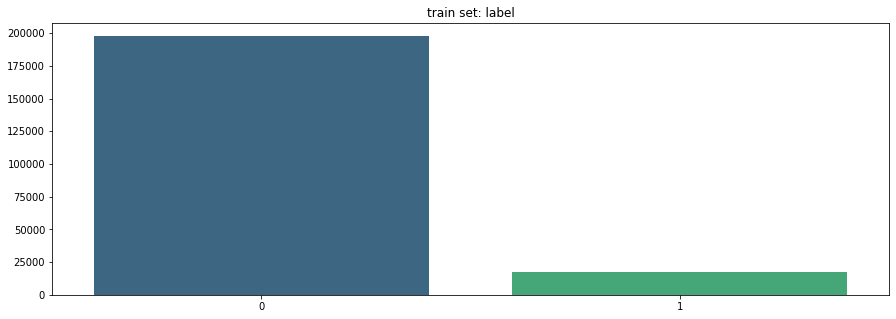

In [35]:
plot_categorical(
    data=train, col='target', size=[15, 5], xlabel_angle=0, title='train set: label')

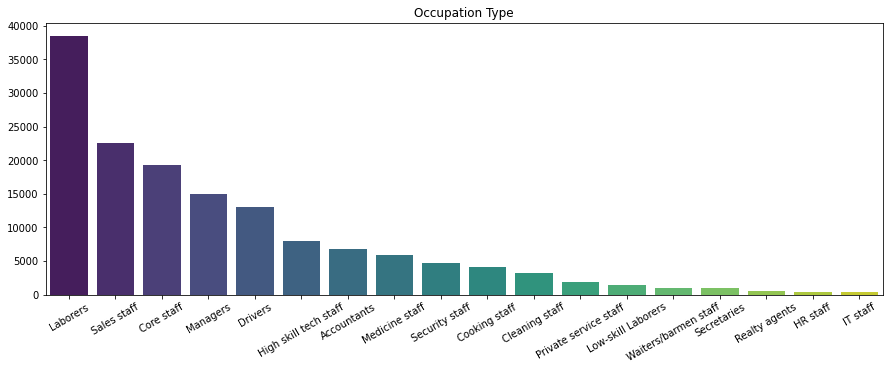

In [36]:
plot_categorical(
    data=train, col='occupation_type', size=[15, 5], xlabel_angle=30, title='Occupation Type')

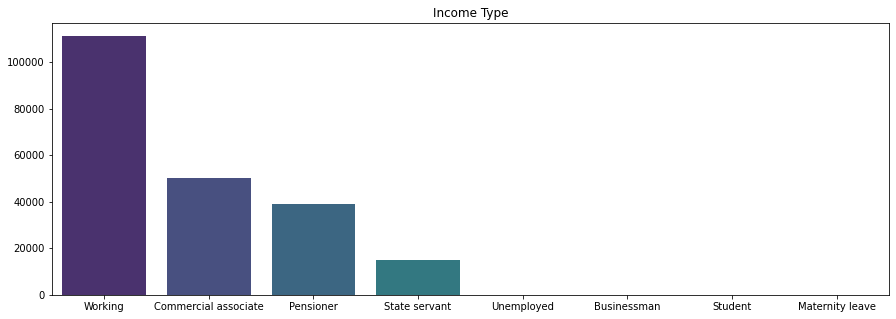

In [37]:
plot_categorical(
    data=train, col='name_income_type', size=[15, 5], xlabel_angle=0, title='Income Type')

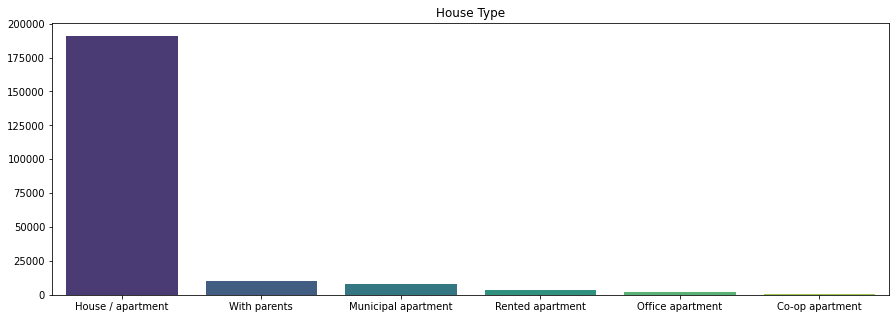

In [38]:
plot_categorical(
    data=train, col='name_housing_type', size=[15, 5], xlabel_angle=0, title='House Type')

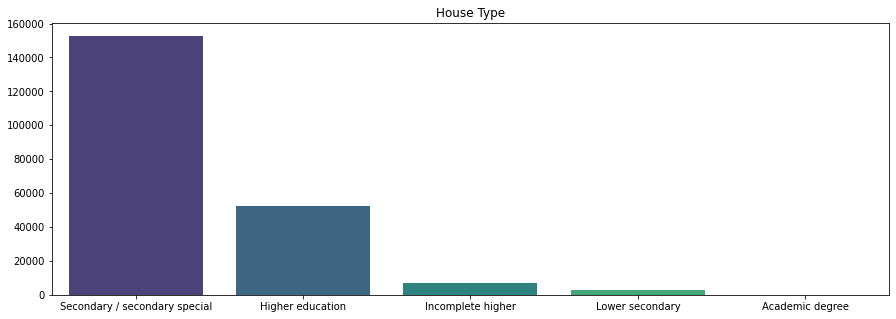

In [39]:
plot_categorical(
    data=train, col='name_education_type', size=[15, 5], xlabel_angle=0, title='House Type')

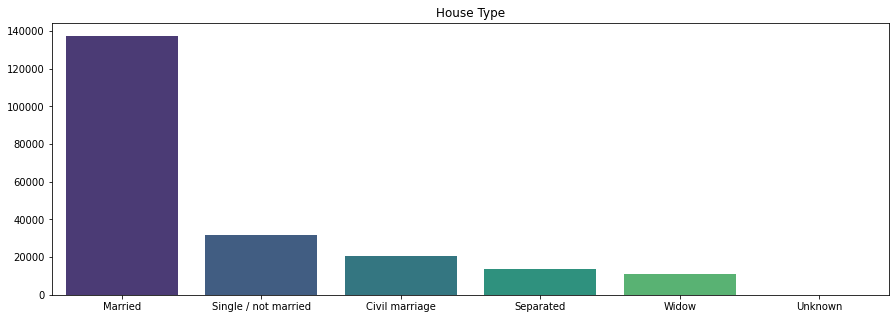

In [40]:
plot_categorical(
    data=train, col='name_family_status', size=[15, 5], xlabel_angle=0, title='House Type')

## Визуализация числовых признаков

The correlation between amt_annuity and target = -0.0118
Median-value for default-loan = 25195.5
Median-value for non default-loan = 25195.5


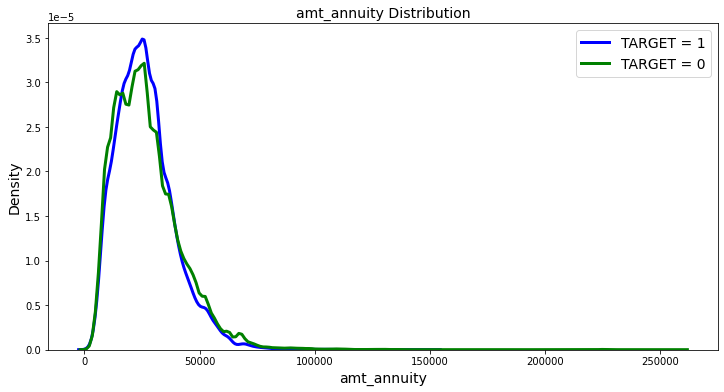

In [41]:
plot_kde_target(
    feature_name="amt_annuity", data=train
)

The correlation between amt_goods_price and target = -0.0378
Median-value for default-loan = 450000.0
Median-value for non default-loan = 450000.0


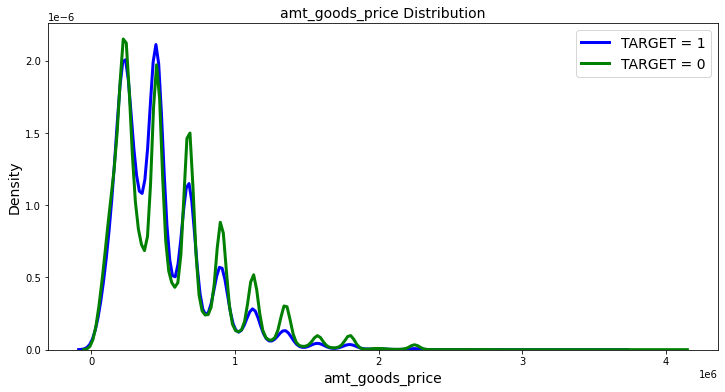

In [42]:
plot_kde_target(
    feature_name="amt_goods_price", data=train
)

The correlation between cnt_fam_members and target = 0.0093
Median-value for default-loan = 2.0
Median-value for non default-loan = 2.0


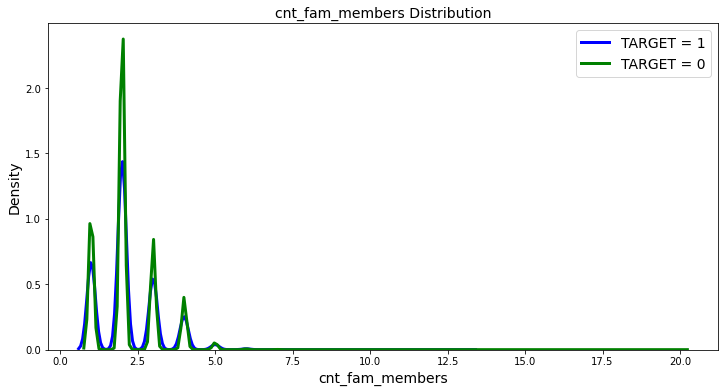

In [27]:
plot_kde_target(
    feature_name="cnt_fam_members", data=train
)

The correlation between ext_source_1 and target = -0.1561
Median-value for default-loan = 0.3604
Median-value for non default-loan = 0.3604


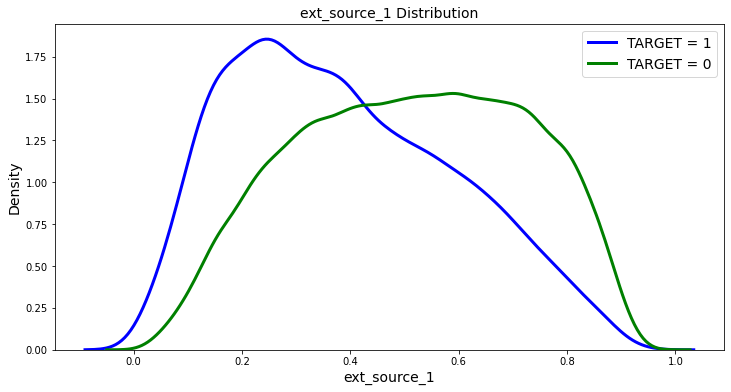

In [28]:
plot_kde_target(
    feature_name="ext_source_1", data=train
)

The correlation between ext_source_2 and target = -0.1585
Median-value for default-loan = 0.4404
Median-value for non default-loan = 0.4404


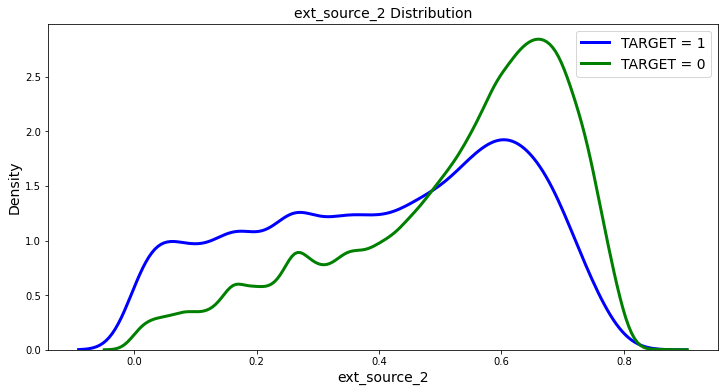

In [29]:
plot_kde_target(
    feature_name="ext_source_2", data=train
)

The correlation between ext_source_3 and target = -0.178
Median-value for default-loan = 0.3825
Median-value for non default-loan = 0.3825


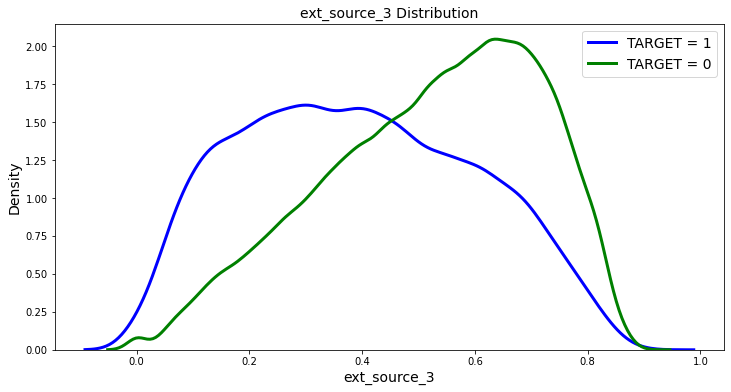

In [30]:
plot_kde_target(
    feature_name="ext_source_3", data=train
)

## Анализ источников данных

In [15]:
n_clients = applications["SK_ID_CURR"].nunique()

print(f"Applications: {applications.shape[0]} rows")
print(f"Unique clients: {n_clients}")

Applications: 1670214 rows
Unique clients: 338857


In [16]:
n_clients = payments["SK_ID_CURR"].nunique()

print(f"payments: {payments.shape[0]} rows")
print(f"Unique clients: {n_clients}")

payments: 13605401 rows
Unique clients: 339587


In [17]:
n_clients = bureau["SK_ID_CURR"].nunique()

print(f"credit history bureau: {bureau.shape[0]} rows")
print(f"Unique clients: {n_clients}")

credit history bureau: 1716428 rows
Unique clients: 305811


In [13]:
train.merge(applications, left_on = 'sk_id_curr', right_on = 'SK_ID_CURR', how = 'left')

,sk_id_curr,target,name_contract_type,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,amt_goods_price,name_type_suite,name_income_type,name_education_type,name_family_status,name_housing_type,region_population_relative,days_birth,days_employed,days_registration,days_id_publish,own_car_age,flag_mobil,flag_emp_phone,flag_work_phone,flag_cont_mobile,flag_phone,flag_email,occupation_type,cnt_fam_members,region_rating_client,region_rating_client_w_city,weekday_appr_process_start,hour_appr_process_start,reg_region_not_live_region,reg_region_not_work_region,live_region_not_work_region,reg_city_not_live_city,reg_city_not_work_city,live_city_not_work_city,organization_type,ext_source_1,ext_source_2,ext_source_3,apartments_avg,basementarea_avg,years_beginexpluatation_avg,years_build_avg,commonarea_avg,elevators_avg,entrances_avg,floorsmax_avg,floorsmin_avg,landarea_avg,livingapartments_avg,livingarea_avg,nonlivingapartments_avg,nonlivingarea_avg,apartments_mode,basementarea_mode,years_beginexpluatation_mode,years_build_mode,commonarea_mode,elevators_mode,entrances_mode,floorsmax_mode,floorsmin_mode,landarea_mode,livingapartments_mode,livingarea_mode,nonlivingapartments_mode,nonlivingarea_mode,apartments_medi,basementarea_medi,years_beginexpluatation_medi,...,nonlivingapartments_medi,nonlivingarea_medi,fondkapremont_mode,housetype_mode,totalarea_mode,wallsmaterial_mode,emergencystate_mode,obs_30_cnt_social_circle,def_30_cnt_social_circle,obs_60_cnt_social_circle,def_60_cnt_social_circle,days_last_phone_change,flag_document_2,flag_document_3,flag_document_4,flag_document_5,flag_document_6,flag_document_7,flag_document_8,flag_document_9,flag_document_10,flag_document_11,flag_document_12,flag_document_13,flag_document_14,flag_document_15,flag_document_16,flag_document_17,flag_document_18,flag_document_19,flag_document_20,flag_document_21,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,342217,0,Revolving loans,F,N,Y,0,202500.0,585000.0,29250.0,585000.0,Unaccompanied,State servant,Higher education,Married,House / apartment,0.007120,-14937,-5026,-1.0,-4606,NaN,1,1,0,1,0,0,Managers,2.0,2,2,FRIDAY,10,0,0,0,0,0,0,Government,NaN,0.612914,0.408359,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-797.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,2.0,1167072.0,342217.0,Cash loans,53277.660,1354500.0,1483231.5,NaN,1354500.0,TUESDAY,9.0,Y,1.0,NaN,NaN,NaN,XNA,Refused,-598.0,Cash through the bank,HC,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1.0,XNA,48.0,low_normal,Cash X-Sell: low,NaN,NaN,NaN,NaN,NaN,NaN
1,342217,0,Revolving loans,F,N,Y,0,202500.0,585000.0,29250.0,585000.0,Unaccompanied,State servant,Higher education,Married,House / apartment,0.007120,-14937,-5026,-1.0,-4606,NaN,1,1,0,1,0,0,Managers,2.0,2,2,FRIDAY,10,0,0,0,0,0,0,Government,NaN,0.612914,0.408359,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-797.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,

In [14]:
train.merge(payments, left_on = 'sk_id_curr', right_on = 'SK_ID_CURR', how = 'left')

,sk_id_curr,target,name_contract_type,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,amt_goods_price,name_type_suite,name_income_type,name_education_type,name_family_status,name_housing_type,region_population_relative,days_birth,days_employed,days_registration,days_id_publish,own_car_age,flag_mobil,flag_emp_phone,flag_work_phone,flag_cont_mobile,flag_phone,flag_email,occupation_type,cnt_fam_members,region_rating_client,region_rating_client_w_city,weekday_appr_process_start,hour_appr_process_start,reg_region_not_live_region,reg_region_not_work_region,live_region_not_work_region,reg_city_not_live_city,reg_city_not_work_city,live_city_not_work_city,organization_type,ext_source_1,ext_source_2,ext_source_3,apartments_avg,basementarea_avg,years_beginexpluatation_avg,years_build_avg,commonarea_avg,elevators_avg,entrances_avg,floorsmax_avg,floorsmin_avg,landarea_avg,livingapartments_avg,livingarea_avg,nonlivingapartments_avg,nonlivingarea_avg,apartments_mode,basementarea_mode,years_beginexpluatation_mode,years_build_mode,commonarea_mode,elevators_mode,entrances_mode,floorsmax_mode,floorsmin_mode,landarea_mode,livingapartments_mode,livingarea_mode,nonlivingapartments_mode,nonlivingarea_mode,apartments_medi,basementarea_medi,years_beginexpluatation_medi,years_build_medi,commonarea_medi,elevators_medi,entrances_medi,floorsmax_medi,floorsmin_medi,landarea_medi,livingapartments_medi,livingarea_medi,nonlivingapartments_medi,nonlivingarea_medi,fondkapremont_mode,housetype_mode,totalarea_mode,wallsmaterial_mode,emergencystate_mode,obs_30_cnt_social_circle,def_30_cnt_social_circle,obs_60_cnt_social_circle,def_60_cnt_social_circle,days_last_phone_change,flag_document_2,flag_document_3,flag_document_4,flag_document_5,flag_document_6,flag_document_7,flag_document_8,flag_document_9,flag_document_10,flag_document_11,flag_document_12,flag_document_13,flag_document_14,flag_document_15,flag_document_16,flag_document_17,flag_document_18,flag_document_19,flag_document_20,flag_document_21,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,342217,0,Revolving loans,F,N,Y,0,202500.0,585000.0,29250.0,585000.0,Unaccompanied,State servant,Higher education,Married,House / apartment,0.007120,-14937,-5026,-1.0,-4606,NaN,1,1,0,1,0,0,Managers,2.0,2,2,FRIDAY,10,0,0,0,0,0,0,Government,NaN,0.612914,0.408359,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-797.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,2.0,2452679.0,342217.0,1.0,3.0,-705.0,-708.0,23194.26,23194.26
1,342217,0,Revolving loans,F,N,Y,0,202500.0,585000.0,29250.0,585000.0,Unaccompanied,State servant,Higher education,Married,House / apartment,0.007120,-14937,-5026,-1.0,-4606,NaN,1,1,0,1,0,0,Managers,2.0,2,2,FRIDAY,10,0,0,0,0,0,0,Government,NaN,0.612914,0.408359,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-797.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,2.0,2452679.0,342217.0,1.0,1.0,-765.0,-776.0,23194.26,23194.26
2,342217,0,Revolving loans,F,N,Y,0,202500.0,585000.0,29250.0,585000.0,Unaccompanied,State servant,Higher education,Married,House / apartment,0.007120,-14937,-5026,-1.0,-4606,NaN,1,1,0,1,0,0,Managers,2.0,2,2,FRIDAY,10,0,0,0,0,0,0,Government,NaN,0.612914,0.408359,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-797.0,0,0,

In [15]:
train.merge(bureau, left_on = 'sk_id_curr', right_on = 'SK_ID_CURR', how = 'left')

,sk_id_curr,target,name_contract_type,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,amt_goods_price,name_type_suite,name_income_type,name_education_type,name_family_status,name_housing_type,region_population_relative,days_birth,days_employed,days_registration,days_id_publish,own_car_age,flag_mobil,flag_emp_phone,flag_work_phone,flag_cont_mobile,flag_phone,flag_email,occupation_type,cnt_fam_members,region_rating_client,region_rating_client_w_city,weekday_appr_process_start,hour_appr_process_start,reg_region_not_live_region,reg_region_not_work_region,live_region_not_work_region,reg_city_not_live_city,reg_city_not_work_city,live_city_not_work_city,organization_type,ext_source_1,ext_source_2,ext_source_3,apartments_avg,basementarea_avg,years_beginexpluatation_avg,years_build_avg,commonarea_avg,elevators_avg,entrances_avg,floorsmax_avg,floorsmin_avg,landarea_avg,livingapartments_avg,livingarea_avg,nonlivingapartments_avg,nonlivingarea_avg,apartments_mode,basementarea_mode,years_beginexpluatation_mode,years_build_mode,commonarea_mode,elevators_mode,entrances_mode,floorsmax_mode,floorsmin_mode,landarea_mode,livingapartments_mode,livingarea_mode,nonlivingapartments_mode,nonlivingarea_mode,apartments_medi,basementarea_medi,years_beginexpluatation_medi,years_build_medi,commonarea_medi,elevators_medi,entrances_medi,floorsmax_medi,floorsmin_medi,landarea_medi,livingapartments_medi,livingarea_medi,nonlivingapartments_medi,nonlivingarea_medi,fondkapremont_mode,housetype_mode,totalarea_mode,wallsmaterial_mode,emergencystate_mode,obs_30_cnt_social_circle,def_30_cnt_social_circle,obs_60_cnt_social_circle,def_60_cnt_social_circle,days_last_phone_change,flag_document_2,flag_document_3,flag_document_4,flag_document_5,flag_document_6,flag_document_7,flag_document_8,flag_document_9,flag_document_10,flag_document_11,flag_document_12,flag_document_13,flag_document_14,flag_document_15,flag_document_16,flag_document_17,flag_document_18,flag_document_19,flag_document_20,flag_document_21,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,342217,0,Revolving loans,F,N,Y,0,202500.0,585000.0,29250.0,585000.0,Unaccompanied,State servant,Higher education,Married,House / apartment,0.007120,-14937,-5026,-1.0,-4606,NaN,1,1,0,1,0,0,Managers,2.0,2,2,FRIDAY,10,0,0,0,0,0,0,Government,NaN,0.612914,0.408359,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-797.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,2.0,342217.0,6757526.0,Closed,currency 1,-1960.0,0.0,-864.0,-1523.0,NaN,0.0,351171.0,0.0,0.0,0.0,Consumer credit,-1111.0,NaN
1,342217,0,Revolving loans,F,N,Y,0,202500.0,585000.0,29250.0,585000.0,Unaccompanied,State servant,Higher education,Married,House / apartment,0.007120,-14937,-5026,-1.0,-4606,NaN,1,1,0,1,0,0,Managers,2.0,2,2,FRIDAY,10,0,0,0,0,0,0,Government,NaN,0.612914,0.408359,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-797.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,2.0,342217.0,6757527.0,Closed,currency 1,-1340.0,0.0,-244.0,-340.0,NaN,0.0,844236.0,0.0,0.0,0.0,Consumer credit,-337.0,NaN
2,342217,0,Revolving loans,F,N,Y,0,202500.0,585000.0,29250.0,585000.0,Unaccompanied,State servant,Higher education,Married,House / apartment,0.007120,-14937,-5026,-1.0,-4606,NaN,1,1,0,1,0,0,Manager

In [16]:
train.merge(credit_card_balance, left_on = 'sk_id_curr', right_on = 'SK_ID_CURR', how = 'left')

,sk_id_curr,target,name_contract_type,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,amt_goods_price,name_type_suite,name_income_type,name_education_type,name_family_status,name_housing_type,region_population_relative,days_birth,days_employed,days_registration,days_id_publish,own_car_age,flag_mobil,flag_emp_phone,flag_work_phone,flag_cont_mobile,flag_phone,flag_email,occupation_type,cnt_fam_members,region_rating_client,region_rating_client_w_city,weekday_appr_process_start,hour_appr_process_start,reg_region_not_live_region,reg_region_not_work_region,live_region_not_work_region,reg_city_not_live_city,reg_city_not_work_city,live_city_not_work_city,organization_type,ext_source_1,ext_source_2,ext_source_3,apartments_avg,basementarea_avg,years_beginexpluatation_avg,years_build_avg,commonarea_avg,elevators_avg,entrances_avg,floorsmax_avg,floorsmin_avg,landarea_avg,livingapartments_avg,livingarea_avg,nonlivingapartments_avg,nonlivingarea_avg,apartments_mode,basementarea_mode,years_beginexpluatation_mode,years_build_mode,commonarea_mode,elevators_mode,entrances_mode,floorsmax_mode,floorsmin_mode,landarea_mode,livingapartments_mode,livingarea_mode,nonlivingapartments_mode,nonlivingarea_mode,apartments_medi,basementarea_medi,years_beginexpluatation_medi,years_build_medi,commonarea_medi,elevators_medi,entrances_medi,floorsmax_medi,floorsmin_medi,landarea_medi,livingapartments_medi,livingarea_medi,nonlivingapartments_medi,nonlivingarea_medi,fondkapremont_mode,housetype_mode,totalarea_mode,wallsmaterial_mode,emergencystate_mode,obs_30_cnt_social_circle,def_30_cnt_social_circle,obs_60_cnt_social_circle,def_60_cnt_social_circle,days_last_phone_change,flag_document_2,flag_document_3,flag_document_4,flag_document_5,flag_document_6,flag_document_7,flag_document_8,flag_document_9,flag_document_10,flag_document_11,flag_document_12,flag_document_13,flag_document_14,flag_document_15,flag_document_16,flag_document_17,flag_document_18,flag_document_19,flag_document_20,flag_document_21,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,342217,0,Revolving loans,F,N,Y,0,202500.0,585000.0,29250.0,585000.0,Unaccompanied,State servant,Higher education,Married,House / apartment,0.007120,-14937,-5026,-1.0,-4606,NaN,1,1,0,1,0,0,Managers,2.0,2,2,FRIDAY,10,0,0,0,0,0,0,Government,NaN,0.612914,0.408359,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-797.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,183133,0,Cash loans,F,N,Y,0,112500.0,656811.0,30564.0,567000.0,"Spouse, partner",Pensioner,Secondary / secondary special,Married,House / apartment,0.016612,-22021,365243,-2979.0,-5036,NaN,1,0,0,1,0,0,NaN,2.0,2,2,MONDAY,11,0,0,0,0,0,0,XNA,NaN,0.703983,0.755740,0.3711,0.2556,0.9955,0.9388,NaN,0.36,0.3103,0.3750,NaN,0.0000,NaN,0.3977,NaN,0.0000,0.3782,0.2653,0.9955,0.9412,NaN,0.3625,0.3103,0.3750,NaN,0.0000,NaN,0.4144,NaN,0.0000,0.3747,0.2556,0.9955,0.9396,NaN,0.36,0.3103,0.3750,NaN,0.0000,NaN,0.4049,NaN,0.0000,NaN,block of flats,0.3983,Panel,No,4.0,0.0,4.0,0.0,-1542.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0,2582160.0,183133.0,-92.0,8453.7,67500.0,0.0,0.0,0.0,0.0,3375.0,675

In [20]:
train.head(n=3)

,sk_id_curr,target,name_contract_type,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,amt_goods_price,name_type_suite,name_income_type,name_education_type,name_family_status,name_housing_type,region_population_relative,days_birth,days_employed,days_registration,days_id_publish,own_car_age,flag_mobil,flag_emp_phone,flag_work_phone,flag_cont_mobile,flag_phone,flag_email,occupation_type,cnt_fam_members,region_rating_client,region_rating_client_w_city,weekday_appr_process_start,hour_appr_process_start,reg_region_not_live_region,reg_region_not_work_region,live_region_not_work_region,reg_city_not_live_city,reg_city_not_work_city,live_city_not_work_city,organization_type,ext_source_1,ext_source_2,ext_source_3,apartments_avg,basementarea_avg,years_beginexpluatation_avg,years_build_avg,commonarea_avg,elevators_avg,entrances_avg,floorsmax_avg,floorsmin_avg,landarea_avg,livingapartments_avg,livingarea_avg,nonlivingapartments_avg,nonlivingarea_avg,apartments_mode,basementarea_mode,years_beginexpluatation_mode,years_build_mode,commonarea_mode,elevators_mode,entrances_mode,floorsmax_mode,floorsmin_mode,landarea_mode,livingapartments_mode,livingarea_mode,nonlivingapartments_mode,nonlivingarea_mode,apartments_medi,basementarea_medi,years_beginexpluatation_medi,years_build_medi,commonarea_medi,elevators_medi,entrances_medi,floorsmax_medi,floorsmin_medi,landarea_medi,livingapartments_medi,livingarea_medi,nonlivingapartments_medi,nonlivingarea_medi,fondkapremont_mode,housetype_mode,totalarea_mode,wallsmaterial_mode,emergencystate_mode,obs_30_cnt_social_circle,def_30_cnt_social_circle,obs_60_cnt_social_circle,def_60_cnt_social_circle,days_last_phone_change,flag_document_2,flag_document_3,flag_document_4,flag_document_5,flag_document_6,flag_document_7,flag_document_8,flag_document_9,flag_document_10,flag_document_11,flag_document_12,flag_document_13,flag_document_14,flag_document_15,flag_document_16,flag_document_17,flag_document_18,flag_document_19,flag_document_20,flag_document_21,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year
0,342217,0,Revolving loans,F,N,Y,0,202500.0,585000.0,29250.0,585000.0,Unaccompanied,State servant,Higher education,Married,House / apartment,0.007120,-14937,-5026,-1.0,-4606,NaN,1,1,0,1,0,0,Managers,2.0,2,2,FRIDAY,10,0,0,0,0,0,0,Government,NaN,0.612914,0.408359,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-797.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,2.0
1,183133,0,Cash loans,F,N,Y,0,112500.0,656811.0,30564.0,567000.0,"Spouse, partner",Pensioner,Secondary / secondary special,Married,House / apartment,0.016612,-22021,365243,-2979.0,-5036,NaN,1,0,0,1,0,0,NaN,2.0,2,2,MONDAY,11,0,0,0,0,0,0,XNA,NaN,0.703983,0.755740,0.3711,0.2556,0.9955,0.9388,NaN,0.36,0.3103,0.3750,NaN,0.0000,NaN,0.3977,NaN,0.0,0.3782,0.2653,0.9955,0.9412,NaN,0.3625,0.3103,0.3750,NaN,0.0000,NaN,0.4144,NaN,0.0,0.3747,0.2556,0.9955,0.9396,NaN,0.36,0.3103,0.3750,NaN,0.0000,NaN,0.4049,NaN,0.0,NaN,block of flats,0.3983,Panel,No,4.0,0.0,4.0,0.0,-1542.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,449106,0,Revolving loans,M,N,Y,0,144000.0,450000.0,22500.0,450000.0,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,0.011703,-9989,-368,-356.0,-1635,NaN,1,1,0,1,0,0,NaN,2.0,2,2,MONDAY,10,0,0,0,0,0,0,Business Entity Type 2,NaN,0.631356,0.754406,0.1031,0.0000,0.9752,0.6600,NaN,0.00,0.1724,0.1667,0.2083,0.0947,NaN,0.0887,NaN,0.0,0.1050,0.0000,0.9752,0.6733,NaN,0.0000,0.1724,0.1667,0.2083,0.0968,NaN,0.0924,NaN,0.0,0.1041,0.0000,0.9752,0.6645,NaN,0.00,0.1724,0.1667,0.2083,0.0963,NaN,0.0903,NaN,0.0,not specified,block of flats,0.0757,Panel,No,1.0,0.0,1.0,0.0,-339.0,0,0,0,1,0,0,0,0,0,0,

## Построение baseline-модели

In [58]:
y_train = train["target"]
X_train = train.drop(["target", "sk_id_curr"], axis=1)
categorical = X_train.dtypes[X_train.dtypes == "object"]
categorical = list(categorical.index)

In [59]:
cb_params = {
    "n_estimators": 1500,
    "learning_rate": 0.01,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "verbose": 25,
    "max_depth": 16,
    "l2_leaf_reg": 10,
    "early_stopping_rounds": 50,
    "thread_count": 8,
    "random_seed": 42
}

estimators, prediction = catboost_hold_out_validation(
    params=cb_params, X=X_train, y=y_train, split_params=[0.6, 0.2, 0.2], categorical=categorical
)

Starting at Sun Jan 30 19:02:04 2022
0:	test: 0.5964294	test1: 0.5847331	best: 0.5847331 (0)	total: 2.06s	remaining: 51m 22s


CatBoostError: bad allocation

In [15]:
%pwd

'C:\\Users\\olegi\\Python-lab-and-homework\\edu-data\\workshop15\\12. Скоринг кредитного портфеля'

In [31]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

In [18]:
import os
import shap
import numpy as np
import pandas as pd
import xgboost as xgb
import catboost as cb
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error

shap.initjs()

In [36]:
train.head(n=3)

,sk_id_curr,target,name_contract_type,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,amt_goods_price,name_type_suite,name_income_type,name_education_type,name_family_status,name_housing_type,region_population_relative,days_birth,days_employed,days_registration,days_id_publish,own_car_age,flag_mobil,flag_emp_phone,flag_work_phone,flag_cont_mobile,flag_phone,flag_email,occupation_type,cnt_fam_members,region_rating_client,region_rating_client_w_city,weekday_appr_process_start,hour_appr_process_start,reg_region_not_live_region,reg_region_not_work_region,live_region_not_work_region,reg_city_not_live_city,reg_city_not_work_city,live_city_not_work_city,organization_type,ext_source_1,ext_source_2,ext_source_3,apartments_avg,basementarea_avg,years_beginexpluatation_avg,years_build_avg,commonarea_avg,elevators_avg,entrances_avg,floorsmax_avg,floorsmin_avg,landarea_avg,livingapartments_avg,livingarea_avg,nonlivingapartments_avg,nonlivingarea_avg,apartments_mode,basementarea_mode,years_beginexpluatation_mode,years_build_mode,commonarea_mode,elevators_mode,entrances_mode,floorsmax_mode,floorsmin_mode,landarea_mode,livingapartments_mode,livingarea_mode,nonlivingapartments_mode,nonlivingarea_mode,apartments_medi,basementarea_medi,years_beginexpluatation_medi,years_build_medi,commonarea_medi,elevators_medi,entrances_medi,floorsmax_medi,floorsmin_medi,landarea_medi,livingapartments_medi,livingarea_medi,nonlivingapartments_medi,nonlivingarea_medi,fondkapremont_mode,housetype_mode,totalarea_mode,wallsmaterial_mode,emergencystate_mode,obs_30_cnt_social_circle,def_30_cnt_social_circle,obs_60_cnt_social_circle,def_60_cnt_social_circle,days_last_phone_change,flag_document_2,flag_document_3,flag_document_4,flag_document_5,flag_document_6,flag_document_7,flag_document_8,flag_document_9,flag_document_10,flag_document_11,flag_document_12,flag_document_13,flag_document_14,flag_document_15,flag_document_16,flag_document_17,flag_document_18,flag_document_19,flag_document_20,flag_document_21,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year
0,342217,0,Revolving loans,F,N,Y,0,202500.0,585000.0,29250.0,585000.0,Unaccompanied,State servant,Higher education,Married,House / apartment,0.007120,-14937,-5026,-1.0,-4606,NaN,1,1,0,1,0,0,Managers,2.0,2,2,FRIDAY,10,0,0,0,0,0,0,Government,NaN,0.612914,0.408359,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-797.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,2.0
1,183133,0,Cash loans,F,N,Y,0,112500.0,656811.0,30564.0,567000.0,"Spouse, partner",Pensioner,Secondary / secondary special,Married,House / apartment,0.016612,-22021,365243,-2979.0,-5036,NaN,1,0,0,1,0,0,NaN,2.0,2,2,MONDAY,11,0,0,0,0,0,0,XNA,NaN,0.703983,0.755740,0.3711,0.2556,0.9955,0.9388,NaN,0.36,0.3103,0.3750,NaN,0.0000,NaN,0.3977,NaN,0.0,0.3782,0.2653,0.9955,0.9412,NaN,0.3625,0.3103,0.3750,NaN,0.0000,NaN,0.4144,NaN,0.0,0.3747,0.2556,0.9955,0.9396,NaN,0.36,0.3103,0.3750,NaN,0.0000,NaN,0.4049,NaN,0.0,NaN,block of flats,0.3983,Panel,No,4.0,0.0,4.0,0.0,-1542.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,449106,0,Revolving loans,M,N,Y,0,144000.0,450000.0,22500.0,450000.0,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,0.011703,-9989,-368,-356.0,-1635,NaN,1,1,0,1,0,0,NaN,2.0,2,2,MONDAY,10,0,0,0,0,0,0,Business Entity Type 2,NaN,0.631356,0.754406,0.1031,0.0000,0.9752,0.6600,NaN,0.00,0.1724,0.1667,0.2083,0.0947,NaN,0.0887,NaN,0.0,0.1050,0.0000,0.9752,0.6733,NaN,0.0000,0.1724,0.1667,0.2083,0.0968,NaN,0.0924,NaN,0.0,0.1041,0.0000,0.9752,0.6645,NaN,0.00,0.1724,0.1667,0.2083,0.0963,NaN,0.0903,NaN,0.0,not specified,block of flats,0.0757,Panel,No,1.0,0.0,1.0,0.0,-339.0,0,0,0,1,0,0,0,0,0,0,

In [21]:
%%time
for c in train.dtypes[train.dtypes == object].keys():
    print ("---- %s ---" % c)
 #   print (train[c].value_counts())

---- name_contract_type ---
---- code_gender ---
---- flag_own_car ---
---- flag_own_realty ---
---- name_type_suite ---
---- name_income_type ---
---- name_education_type ---
---- name_family_status ---
---- name_housing_type ---
---- occupation_type ---
---- weekday_appr_process_start ---
---- organization_type ---
---- fondkapremont_mode ---
---- housetype_mode ---
---- wallsmaterial_mode ---
---- emergencystate_mode ---
Wall time: 0 ns


In [27]:
cat_features = ['name_contract_type',
'code_gender',
'flag_own_car',
'flag_own_realty',
'name_type_suite',
'name_income_type',
'name_education_type',
'name_family_status',
'name_housing_type',
'occupation_type',
'weekday_appr_process_start',
'organization_type',
'fondkapremont_mode',
'housetype_mode',
'wallsmaterial_mode',
'emergencystate_mode']

In [28]:
from sklearn.preprocessing import OrdinalEncoder

In [29]:
enc = OrdinalEncoder()

In [30]:
train[cat_features] = enc.fit_transform(train[cat_features])
train[cat_features] = enc.transform(train[cat_features])

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [31]:
train[cat_features].head(n=4)

,name_contract_type,code_gender,flag_own_car,flag_own_realty,name_type_suite,name_income_type,name_education_type,name_family_status,name_housing_type,occupation_type,weekday_appr_process_start,organization_type,fondkapremont_mode,housetype_mode,wallsmaterial_mode,emergencystate_mode
0,1.0,0.0,0.0,1.0,6.0,4.0,1.0,1.0,1.0,10.0,0.0,11.0,NaN,NaN,NaN,NaN
1,0.0,0.0,0.0,1.0,5.0,3.0,4.0,1.0,1.0,NaN,1.0,57.0,NaN,0.0,4.0,0.0
2,1.0,1.0,0.0,1.0,6.0,1.0,4.0,1.0,1.0,NaN,1.0,4.0,0.0,0.0,4.0,0.0
3,0.0,0.0,0.0,1.0,6.0,4.0,1.0,1.0,1.0,NaN,0.0,41.0,NaN,0.0,5.0,0.0


In [32]:
%%time
for c in test.dtypes[test.dtypes == object].keys():
    print ("---- %s ---" % c)

---- name_contract_type ---
---- code_gender ---
---- flag_own_car ---
---- flag_own_realty ---
---- name_type_suite ---
---- name_income_type ---
---- name_education_type ---
---- name_family_status ---
---- name_housing_type ---
---- occupation_type ---
---- weekday_appr_process_start ---
---- organization_type ---
---- fondkapremont_mode ---
---- housetype_mode ---
---- wallsmaterial_mode ---
---- emergencystate_mode ---
Wall time: 0 ns


In [33]:
test[cat_features] = enc.fit_transform(test[cat_features])
test[cat_features] = enc.transform(test[cat_features])

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [34]:
test.head(n=3)

,sk_id_curr,name_contract_type,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,amt_goods_price,name_type_suite,name_income_type,name_education_type,name_family_status,name_housing_type,region_population_relative,days_birth,days_employed,days_registration,days_id_publish,own_car_age,flag_mobil,flag_emp_phone,flag_work_phone,flag_cont_mobile,flag_phone,flag_email,occupation_type,cnt_fam_members,region_rating_client,region_rating_client_w_city,weekday_appr_process_start,hour_appr_process_start,reg_region_not_live_region,reg_region_not_work_region,live_region_not_work_region,reg_city_not_live_city,reg_city_not_work_city,live_city_not_work_city,organization_type,ext_source_1,ext_source_2,ext_source_3,apartments_avg,basementarea_avg,years_beginexpluatation_avg,years_build_avg,commonarea_avg,elevators_avg,entrances_avg,floorsmax_avg,floorsmin_avg,landarea_avg,livingapartments_avg,livingarea_avg,nonlivingapartments_avg,nonlivingarea_avg,apartments_mode,basementarea_mode,years_beginexpluatation_mode,years_build_mode,commonarea_mode,elevators_mode,entrances_mode,floorsmax_mode,floorsmin_mode,landarea_mode,livingapartments_mode,livingarea_mode,nonlivingapartments_mode,nonlivingarea_mode,apartments_medi,basementarea_medi,years_beginexpluatation_medi,years_build_medi,commonarea_medi,elevators_medi,entrances_medi,floorsmax_medi,floorsmin_medi,landarea_medi,livingapartments_medi,livingarea_medi,nonlivingapartments_medi,nonlivingarea_medi,fondkapremont_mode,housetype_mode,totalarea_mode,wallsmaterial_mode,emergencystate_mode,obs_30_cnt_social_circle,def_30_cnt_social_circle,obs_60_cnt_social_circle,def_60_cnt_social_circle,days_last_phone_change,flag_document_2,flag_document_3,flag_document_4,flag_document_5,flag_document_6,flag_document_7,flag_document_8,flag_document_9,flag_document_10,flag_document_11,flag_document_12,flag_document_13,flag_document_14,flag_document_15,flag_document_16,flag_document_17,flag_document_18,flag_document_19,flag_document_20,flag_document_21,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year
0,174545,0.0,0.0,0.0,1.0,0,135000.0,654498.0,31617.0,585000.0,6.0,2.0,4.0,1.0,1.0,0.005313,-20614,365243,-8985.0,-3098,NaN,1,0,0,1,0,0,NaN,2.0,2,2,5.0,9,0,0,0,0,0,0,57.0,NaN,0.622652,0.602386,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-1237.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
1,209898,0.0,1.0,1.0,1.0,0,135000.0,234576.0,25393.5,202500.0,6.0,6.0,4.0,3.0,5.0,0.010643,-9080,-1080,-1909.0,-1743,13.0,1,1,0,1,0,0,4.0,1.0,2,2,5.0,17,0,0,0,0,0,0,11.0,NaN,0.655960,0.492060,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1.0,0.0,-379.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0
2,454938,0.0,1.0,1.0,1.0,0,112500.0,157914.0,16753.5,139500.0,6.0,6.0,4.0,3.0,1.0,0.032561,-15933,-114,-7826.0,-4424,19.0,1,1,0,1,0,0,8.0,1.0,1,1,5.0,14,0,1,1,0,0,0,33.0,0.690999,0.670793,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.1682,NaN,0.0,1.0,0.0,1.0,0.0,-343.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0


In [60]:
y_train = train["target"]
X_train = train.drop(["target", "sk_id_curr"], axis=1)
#categorical = X_train.dtypes[X_train.dtypes == "object"]
#categorical = list(categorical.index)

In [36]:
x_train, x_valid = train_test_split(
    train.drop(["sk_id_curr", "target"], axis=1), train_size=0.7, random_state=1
)
y_train, y_valid = train_test_split(
    train["target"], train_size=0.7, random_state=1
)

In [41]:
xgb_params = {
    "booster": "gbtree",
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "learning_rate": 0.1,
    "reg_lambda": 100,
    "max_depth": 4,
    "nthread": 6,
    "gamma": 10,
    "seed": 27
}

dtrain = xgb.DMatrix(
    data=x_train, label=y_train
)
dvalid = xgb.DMatrix(
    data=x_valid, label=y_valid
)

In [42]:
evals_result = {}

model = xgb.train(
    params=xgb_params,
    dtrain=dtrain,
    num_boost_round=1000,
    maximize=True,
    early_stopping_rounds=50,
    evals_result=evals_result,
    evals=[(dtrain, "train"), (dvalid, "valid")],
    verbose_eval=25,
    
)

[0]	train-auc:0.632416	valid-auc:0.628025
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 50 rounds.
[25]	train-auc:0.729353	valid-auc:0.717891
[50]	train-auc:0.752178	valid-auc:0.736135
[75]	train-auc:0.760745	valid-auc:0.741903
[100]	train-auc:0.76519	valid-auc:0.744549
[125]	train-auc:0.766766	valid-auc:0.745575
[150]	train-auc:0.766766	valid-auc:0.745575
Stopping. Best iteration:
[116]	train-auc:0.766766	valid-auc:0.745575



In [35]:
model = cb.CatBoostClassifier(random_state=27)
model.fit(X_train, y_train)

CatBoostError: Bad value for num_feature[non_default_doc_idx=0,feature_idx=0]="Revolving loans": Cannot convert 'b'Revolving loans'' to float

In [94]:
test[cat_features] = enc.fit_transform(test[cat_features])
test[cat_features] = enc.transform(test[cat_features])

In [47]:
test.head(n=3)

,sk_id_curr,name_contract_type,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,amt_goods_price,name_type_suite,name_income_type,name_education_type,name_family_status,name_housing_type,region_population_relative,days_birth,days_employed,days_registration,days_id_publish,own_car_age,flag_mobil,flag_emp_phone,flag_work_phone,flag_cont_mobile,flag_phone,flag_email,occupation_type,cnt_fam_members,region_rating_client,region_rating_client_w_city,weekday_appr_process_start,hour_appr_process_start,reg_region_not_live_region,reg_region_not_work_region,live_region_not_work_region,reg_city_not_live_city,reg_city_not_work_city,live_city_not_work_city,organization_type,ext_source_1,ext_source_2,ext_source_3,apartments_avg,basementarea_avg,years_beginexpluatation_avg,years_build_avg,commonarea_avg,elevators_avg,entrances_avg,floorsmax_avg,floorsmin_avg,landarea_avg,livingapartments_avg,livingarea_avg,nonlivingapartments_avg,nonlivingarea_avg,apartments_mode,basementarea_mode,years_beginexpluatation_mode,years_build_mode,commonarea_mode,elevators_mode,entrances_mode,floorsmax_mode,floorsmin_mode,landarea_mode,livingapartments_mode,livingarea_mode,nonlivingapartments_mode,nonlivingarea_mode,apartments_medi,basementarea_medi,years_beginexpluatation_medi,years_build_medi,commonarea_medi,elevators_medi,entrances_medi,floorsmax_medi,floorsmin_medi,landarea_medi,livingapartments_medi,livingarea_medi,nonlivingapartments_medi,nonlivingarea_medi,fondkapremont_mode,housetype_mode,totalarea_mode,wallsmaterial_mode,emergencystate_mode,obs_30_cnt_social_circle,def_30_cnt_social_circle,obs_60_cnt_social_circle,def_60_cnt_social_circle,days_last_phone_change,flag_document_2,flag_document_3,flag_document_4,flag_document_5,flag_document_6,flag_document_7,flag_document_8,flag_document_9,flag_document_10,flag_document_11,flag_document_12,flag_document_13,flag_document_14,flag_document_15,flag_document_16,flag_document_17,flag_document_18,flag_document_19,flag_document_20,flag_document_21,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year
0,174545,0.0,0.0,0.0,1.0,0,135000.0,654498.0,31617.0,585000.0,6.0,2.0,4.0,1.0,1.0,0.005313,-20614,365243,-8985.0,-3098,NaN,1,0,0,1,0,0,NaN,2.0,2,2,5.0,9,0,0,0,0,0,0,57.0,NaN,0.622652,0.602386,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-1237.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
1,209898,0.0,1.0,1.0,1.0,0,135000.0,234576.0,25393.5,202500.0,6.0,6.0,4.0,3.0,5.0,0.010643,-9080,-1080,-1909.0,-1743,13.0,1,1,0,1,0,0,4.0,1.0,2,2,5.0,17,0,0,0,0,0,0,11.0,NaN,0.655960,0.492060,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1.0,0.0,-379.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0
2,454938,0.0,1.0,1.0,1.0,0,112500.0,157914.0,16753.5,139500.0,6.0,6.0,4.0,3.0,1.0,0.032561,-15933,-114,-7826.0,-4424,19.0,1,1,0,1,0,0,8.0,1.0,1,1,5.0,14,0,1,1,0,0,0,33.0,0.690999,0.670793,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.1682,NaN,0.0,1.0,0.0,1.0,0.0,-343.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0


In [48]:
test2=test.drop(["sk_id_curr"], axis=1)

In [50]:
baseline = xgb.XGBClassifier(random_state=27)
baseline.fit(x_train, y_train)

XGBClassifier(random_state=27)

In [51]:
test.head(n=3)

,sk_id_curr,name_contract_type,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,amt_goods_price,name_type_suite,name_income_type,name_education_type,name_family_status,name_housing_type,region_population_relative,days_birth,days_employed,days_registration,days_id_publish,own_car_age,flag_mobil,flag_emp_phone,flag_work_phone,flag_cont_mobile,flag_phone,flag_email,occupation_type,cnt_fam_members,region_rating_client,region_rating_client_w_city,weekday_appr_process_start,hour_appr_process_start,reg_region_not_live_region,reg_region_not_work_region,live_region_not_work_region,reg_city_not_live_city,reg_city_not_work_city,live_city_not_work_city,organization_type,ext_source_1,ext_source_2,ext_source_3,apartments_avg,basementarea_avg,years_beginexpluatation_avg,years_build_avg,commonarea_avg,elevators_avg,entrances_avg,floorsmax_avg,floorsmin_avg,landarea_avg,livingapartments_avg,livingarea_avg,nonlivingapartments_avg,nonlivingarea_avg,apartments_mode,basementarea_mode,years_beginexpluatation_mode,years_build_mode,commonarea_mode,elevators_mode,entrances_mode,floorsmax_mode,floorsmin_mode,landarea_mode,livingapartments_mode,livingarea_mode,nonlivingapartments_mode,nonlivingarea_mode,apartments_medi,basementarea_medi,years_beginexpluatation_medi,years_build_medi,commonarea_medi,elevators_medi,entrances_medi,floorsmax_medi,floorsmin_medi,landarea_medi,livingapartments_medi,livingarea_medi,nonlivingapartments_medi,nonlivingarea_medi,fondkapremont_mode,housetype_mode,totalarea_mode,wallsmaterial_mode,emergencystate_mode,obs_30_cnt_social_circle,def_30_cnt_social_circle,obs_60_cnt_social_circle,def_60_cnt_social_circle,days_last_phone_change,flag_document_2,flag_document_3,flag_document_4,flag_document_5,flag_document_6,flag_document_7,flag_document_8,flag_document_9,flag_document_10,flag_document_11,flag_document_12,flag_document_13,flag_document_14,flag_document_15,flag_document_16,flag_document_17,flag_document_18,flag_document_19,flag_document_20,flag_document_21,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year
0,174545,0.0,0.0,0.0,1.0,0,135000.0,654498.0,31617.0,585000.0,6.0,2.0,4.0,1.0,1.0,0.005313,-20614,365243,-8985.0,-3098,NaN,1,0,0,1,0,0,NaN,2.0,2,2,5.0,9,0,0,0,0,0,0,57.0,NaN,0.622652,0.602386,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-1237.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
1,209898,0.0,1.0,1.0,1.0,0,135000.0,234576.0,25393.5,202500.0,6.0,6.0,4.0,3.0,5.0,0.010643,-9080,-1080,-1909.0,-1743,13.0,1,1,0,1,0,0,4.0,1.0,2,2,5.0,17,0,0,0,0,0,0,11.0,NaN,0.655960,0.492060,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1.0,0.0,-379.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0
2,454938,0.0,1.0,1.0,1.0,0,112500.0,157914.0,16753.5,139500.0,6.0,6.0,4.0,3.0,1.0,0.032561,-15933,-114,-7826.0,-4424,19.0,1,1,0,1,0,0,8.0,1.0,1,1,5.0,14,0,1,1,0,0,0,33.0,0.690999,0.670793,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.1682,NaN,0.0,1.0,0.0,1.0,0.0,-343.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0


In [52]:
test2.head(n=3)

,name_contract_type,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,amt_goods_price,name_type_suite,name_income_type,name_education_type,name_family_status,name_housing_type,region_population_relative,days_birth,days_employed,days_registration,days_id_publish,own_car_age,flag_mobil,flag_emp_phone,flag_work_phone,flag_cont_mobile,flag_phone,flag_email,occupation_type,cnt_fam_members,region_rating_client,region_rating_client_w_city,weekday_appr_process_start,hour_appr_process_start,reg_region_not_live_region,reg_region_not_work_region,live_region_not_work_region,reg_city_not_live_city,reg_city_not_work_city,live_city_not_work_city,organization_type,ext_source_1,ext_source_2,ext_source_3,apartments_avg,basementarea_avg,years_beginexpluatation_avg,years_build_avg,commonarea_avg,elevators_avg,entrances_avg,floorsmax_avg,floorsmin_avg,landarea_avg,livingapartments_avg,livingarea_avg,nonlivingapartments_avg,nonlivingarea_avg,apartments_mode,basementarea_mode,years_beginexpluatation_mode,years_build_mode,commonarea_mode,elevators_mode,entrances_mode,floorsmax_mode,floorsmin_mode,landarea_mode,livingapartments_mode,livingarea_mode,nonlivingapartments_mode,nonlivingarea_mode,apartments_medi,basementarea_medi,years_beginexpluatation_medi,years_build_medi,commonarea_medi,elevators_medi,entrances_medi,floorsmax_medi,floorsmin_medi,landarea_medi,livingapartments_medi,livingarea_medi,nonlivingapartments_medi,nonlivingarea_medi,fondkapremont_mode,housetype_mode,totalarea_mode,wallsmaterial_mode,emergencystate_mode,obs_30_cnt_social_circle,def_30_cnt_social_circle,obs_60_cnt_social_circle,def_60_cnt_social_circle,days_last_phone_change,flag_document_2,flag_document_3,flag_document_4,flag_document_5,flag_document_6,flag_document_7,flag_document_8,flag_document_9,flag_document_10,flag_document_11,flag_document_12,flag_document_13,flag_document_14,flag_document_15,flag_document_16,flag_document_17,flag_document_18,flag_document_19,flag_document_20,flag_document_21,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year
0,0.0,0.0,0.0,1.0,0,135000.0,654498.0,31617.0,585000.0,6.0,2.0,4.0,1.0,1.0,0.005313,-20614,365243,-8985.0,-3098,NaN,1,0,0,1,0,0,NaN,2.0,2,2,5.0,9,0,0,0,0,0,0,57.0,NaN,0.622652,0.602386,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-1237.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
1,0.0,1.0,1.0,1.0,0,135000.0,234576.0,25393.5,202500.0,6.0,6.0,4.0,3.0,5.0,0.010643,-9080,-1080,-1909.0,-1743,13.0,1,1,0,1,0,0,4.0,1.0,2,2,5.0,17,0,0,0,0,0,0,11.0,NaN,0.655960,0.492060,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1.0,0.0,-379.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,1.0,1.0,1.0,0,112500.0,157914.0,16753.5,139500.0,6.0,6.0,4.0,3.0,1.0,0.032561,-15933,-114,-7826.0,-4424,19.0,1,1,0,1,0,0,8.0,1.0,1,1,5.0,14,0,1,1,0,0,0,33.0,0.690999,0.670793,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.1682,NaN,0.0,1.0,0.0,1.0,0.0,-343.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0


In [53]:
prediction = baseline.predict_proba(test2)

In [54]:
prediction

array([[0.9642036 , 0.03579639],
       [0.91980785, 0.08019215],
       [0.9623249 , 0.03767507],
       ...,
       [0.97074294, 0.02925707],
       [0.9666571 , 0.03334291],
       [0.9743582 , 0.02564179]], dtype=float32)

In [55]:
len(prediction)

92254

In [72]:
len(test)

92254

In [85]:
def fit_evaluate_model(estimator, X_train, y_train, test):
    """
    Функция для обучения и оценки качества модели.

    Parameters
    ----------
    estimator: callable
        Объект для обучения и применения модели.

    x_train: pandas.DataFrame
        Матрица признаков для обучения модели.

    y_train: pandas.Series
        Вектор целевой переменной для обучения модели.

    x_valid: pandas.DataFrame
        Матрица признаков для валидации модели.

    y_valid: pandas.Series
        Вектор целевой переменной для валидации модели.

    Returns
    -------
    y_train_pred: np.array
        Вектор прогнозов для обучающей выборки

    y_valid_pred: np.array
        Вектор прогнозов для валидационной выборки

    """
    estimator.fit(x_train, y_train)
    y_train_pred = estimator.predict_proba(X_train)[:, 1]
    y_valid_pred = estimator.predict_proba(test)[:, 1]

  #  train_score = roc_auc_score(y_train, y_train_pred)
 #   valid_score = roc_auc_score(y_valid, y_valid_pred)
  #  print(f"Model Score: train = {round(train_score, 4)})

    return y_train_pred, y_valid_pred

In [87]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split, validation_curve, learning_curve

In [89]:
from sklearn.impute import SimpleImputer

In [90]:
# Создадим класс обработчика пропущенных значений
# Будем заполнять самым частым значением
imp_cat = SimpleImputer(strategy="most_frequent")

In [92]:
%%time
train[cat_features] = imp_cat.fit_transform(train[cat_features])
test[cat_features] = imp_cat.transform(test[cat_features])

Wall time: 187 ms


In [100]:
numeric_features = train.dtypes[(train.dtypes == np.float64) | (train.dtypes == np.int64)].keys().tolist()

In [102]:
cat_bin_features = []
for i in numeric_features:
    if len(train[i].value_counts().keys().tolist()) == 2:
        cat_bin_features.append(i)

In [103]:
cat_bin_features

['target',
 'name_contract_type',
 'flag_own_car',
 'flag_own_realty',
 'flag_mobil',
 'flag_emp_phone',
 'flag_work_phone',
 'flag_cont_mobile',
 'flag_phone',
 'flag_email',
 'reg_region_not_live_region',
 'reg_region_not_work_region',
 'live_region_not_work_region',
 'reg_city_not_live_city',
 'reg_city_not_work_city',
 'live_city_not_work_city',
 'emergencystate_mode',
 'flag_document_2',
 'flag_document_3',
 'flag_document_4',
 'flag_document_5',
 'flag_document_6',
 'flag_document_7',
 'flag_document_8',
 'flag_document_9',
 'flag_document_10',
 'flag_document_11',
 'flag_document_12',
 'flag_document_13',
 'flag_document_14',
 'flag_document_15',
 'flag_document_16',
 'flag_document_17',
 'flag_document_18',
 'flag_document_19',
 'flag_document_20',
 'flag_document_21']

In [104]:
imp_bin_cat = SimpleImputer(strategy="most_frequent")

In [106]:
%%time
train[cat_bin_features] = imp_cat.fit_transform(train[cat_bin_features])
test[cat_bin_features] = imp_cat.transform(test[cat_bin_features])

KeyError: "['target'] not in index"

In [96]:
train.isnull().values.any()

True

In [97]:
test.isnull().values.any()

True

In [95]:
tree = DecisionTreeClassifier(
    max_depth=5, random_state=27
)
y_train_pred, y_valid_pred = fit_evaluate_model(
    tree, X_train, y_train, test2
)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [ ]:
y_valid_pred

## Прогнозирование и проверка качества

In [28]:
test[categorical] = test[categorical].astype(str)
prediction = estimators.predict_proba(test.drop("sk_id_curr", axis=1))[:, 1]

submit = pd.DataFrame({
    "sk_id_curr": test["sk_id_curr"],
    "score": prediction
})
submit.head(n=3)

,sk_id_curr,score
0,174545,0.035286
1,209898,0.059205
2,454938,0.039896


In [56]:
submit = pd.DataFrame({
    "sk_id_curr": test["sk_id_curr"],
    "score": prediction[:,1]
})
submit.head(n=3)

,sk_id_curr,score
0,174545,0.035796
1,209898,0.080192
2,454938,0.037675


In [57]:
bot = RiskDefaultPrediction()
bot.production_quality(answer=submit)

Привет! Приятно познакомиться!
Запускаю тестирование...
Проверяю метрики...
Твой результат: 0.7565759920693752
Думаю...
Может быть имеет смысл сделать отбор признаков? Удалить все лишнее?
Нужно качество больше 0.77, я верю - у тебя получится!
